In [1]:
from shapely import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
shapefile = gpd.read_file("./Shapefiles/Breda.shp")

income = pd.read_csv("./Datasets/Income.csv")
incomekey = {1: "€21,100 to €30,300", 2: "€30,300 to €42,800", 3: "€42,800 to €59,800", 4: "€59,800 +"}

data = pd.read_csv("./Datasets/Green.csv")
data = data.drop(columns = ["Year", "Image ID", "Date", "CBS Grid Code"])

In [3]:
def identify_neighborhood(lon, lat):
    location = Point(lon, lat)
    contains = shapefile.geometry.contains(location)
    try:
        return shapefile.loc[contains, "BUURT"].iloc[0]
    except:
        return None
    
def mean_green_score(dataframe, column, scores, value):
    try:
        return dataframe.loc[dataframe[column] == value, scores].mean()
    except:
        return None

In [4]:
tqdm.pandas(desc = "Splitting coordinates...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: x.str.split(","))

tqdm.pandas(desc = "Converting to numeric...")
data[["Longitude", "Latitude"]] = data[["Longitude", "Latitude"]].progress_apply(lambda x: pd.to_numeric(x.str[0] + "." + x.str[1]))

tqdm.pandas(desc = "Identifying neighborhoods...")
data["Neighborhood"] = data.progress_apply(lambda row: identify_neighborhood(row["Longitude"], row["Latitude"]), axis = 1)

merged = data.merge(income, on = "Neighborhood", how = "left")
merged = merged.drop(columns = ["Latitude", "Longitude"])
merged["Average Green Score"] = merged.groupby("Neighborhood")["Green Score"].transform("mean")
merged["Income"] = merged["Income Index"].map(incomekey)
merged = merged.drop(columns = ["Green Score"])
merged = merged.drop_duplicates()

merged.to_csv("./Datasets/Merged.csv", index = False)

geodata = shapefile.merge(merged, left_on = "BUURT", right_on = "Neighborhood", how = "left")
geodata["Income"] = geodata["Income Index"].map(incomekey)
geodata["Income"].fillna("No Data", inplace = True)

Identifying neighborhoods...: 100%|██████████| 298038/298038 [00:31<00:00, 9582.69it/s] 


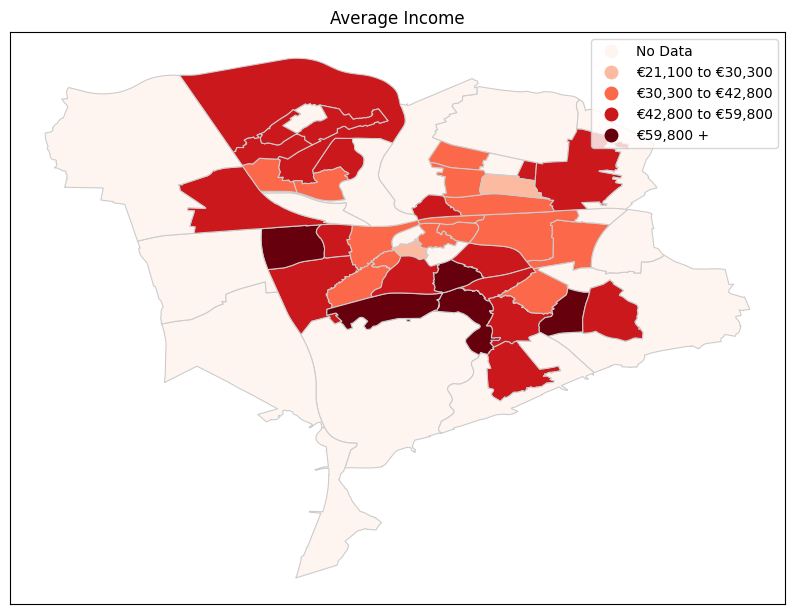

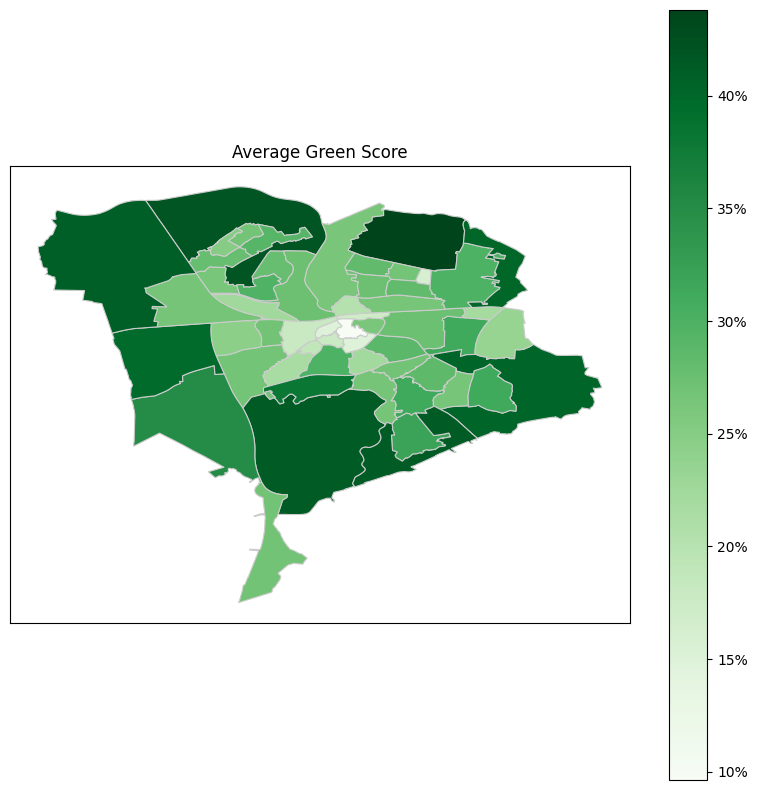

/var/folders/yj/tlnytz_95x13vfm_gll8n6xh0000gn/T/ipykernel_9229/3599238479.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([incomekey.get(int(x), x) for x in ax.get_xticks()])


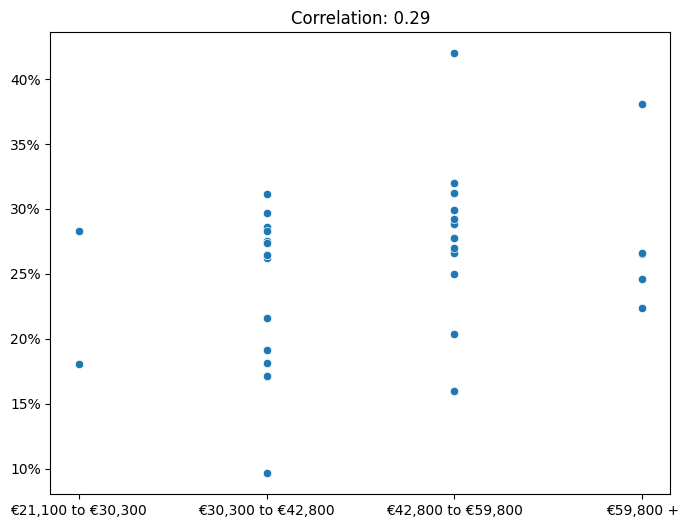

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 10))
geodata.plot(column = "Income", cmap = "Reds", linewidth = 0.8, ax = ax1, edgecolor = "0.8", legend = True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")
plt.title("Average Income")
plt.show()

fig, ax2 = plt.subplots(figsize = (10, 10))
geodata.plot(column = "Average Green Score", cmap = "Greens", linewidth = 0.8, ax = ax2, edgecolor = "0.8", legend = True, legend_kwds = {"format": ticker.PercentFormatter(decimals = 0)})
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")
plt.title("Average Green Score")
plt.show()

correlation = geodata["Income Index"].corr(geodata["Average Green Score"])

fig, ax = plt.subplots(figsize = (8, 6))

sns.scatterplot(data = geodata, x = "Income Index", y = "Average Green Score", ax = ax)

ax.set_xlabel("")
ax.set_ylabel("")

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer = True))
ax.set_xticklabels([incomekey.get(int(x), x) for x in ax.get_xticks()])

ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals = 0))

ax.set_title(f"Correlation: {correlation:.2f}")

plt.show()